### Experimenting augmentations
In this file, I want to create a Dataset object from the generator object so that I can apply Albumentation transformations dependant on the images' labels

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import albumentations as A
import help_functions as hf
import json

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
with open('training_configurations.json', 'r') as fp:
    config = json.load(fp)[str(11)]
config['nr_classes'] = 5
config['batch_size'] = 512
train, train_df = hf.get_flow(df_file=config['data_folder'] + '/test_df.json.bz2',
                   nr_classes=config['nr_classes'],
                   batch_size=config['batch_size'],
                   image_dimension=config['image_dimension'])

Found 50000 non-validated image filenames belonging to 40 classes.


/home/matvieir/wiki_image_classification/src/classification/help_functions.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x_labels['labels'] = df['labels'].apply(lambda labels_list: [label for label in labels_list if label in top_classes])


Found 42671 validated image filenames belonging to 5 classes.


Test constructing tf.data from scratch, didn't really work

In [ ]:
# # Don't
# data_dir = '/scratch/WIT_Dataset/images'
# train_files = train_df.url.apply(lambda filename: data_dir + '/' + filename)
# train_files_array = train_files.values
# train_files_list = train_files_array.tolist()
# list_ds = tf.data.Dataset.list_files(str(data_dir + '/*/*/*'), shuffle=True)
# for f in list_ds.take(50000):
#     filename = urllib.parse.unquote(f.numpy().decode()).encode().decode('unicode-escape')
#     if filename in train_files_list:
#         print(filename)
# print(tf.data.experimental.cardinality(list_ds).numpy())

# def is_in_dataframe(filename, files_list):
#     str_filename = urllib.parse.unquote(filename.numpy().decode()).encode().decode('unicode-escape')
#     return str_filename in files_list

# # Get train_ds if file is in train_df.file
# train_ds = list_ds.filter(lambda file: file.ref() in train_files)

Trying creating dataset from generator tips, following this https://albumentations.ai/docs/examples/tensorflow-example/ and this https://www.kaggle.com/code/junyingsg/tf-data-pipeline-with-albumentation-cutmix-up and this https://www.tensorflow.org/guide/data#consuming_python_generators.

I want to use tf.Data.Dataset.from_generator since the generator object 'flow' has the reference to all of the images that are in the training dataframe train_df. 

In [4]:
datagen = ImageDataGenerator() 
flow = datagen.flow_from_dataframe(
        dataframe=train_df, 
        directory='/scratch/WIT_Dataset/images',
        color_mode='rgb',
        batch_size=config['batch_size'],
        x_col='url', 
        y_col='labels', 
        class_mode='categorical', 
        target_size=(config['image_dimension'], config['image_dimension']),
        shuffle=False)

train_ds = tf.data.Dataset.from_generator(
    lambda: flow, 
    output_types=(tf.float32, tf.float32), 
)

for images, labels in train_ds.take(1):
  print('images.shape: ', images.shape)
  print('labels.shape: ', labels.shape)

Found 42671 validated image filenames belonging to 5 classes.
images.shape:  (512, 64, 64, 3)
labels.shape:  (512, 5)


Note that the visualization of the images without any data augmentation works as expected.

viewing images
(512, 64, 64, 3)
(512, 5)
[[0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 1. 1.]
 ...
 [0. 1. 0. 1. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]


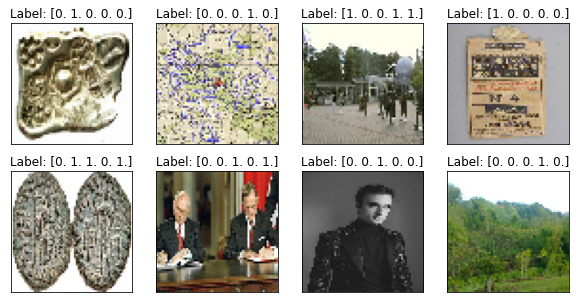

In [28]:
def view_image(ds):
    print('viewing images')
    image, label = next(iter(ds)) # extract 1 batch from the dataset
    print(image.shape)
    print(label.shape)
    image = image.numpy()
    label = label.numpy()
    fig = plt.figure(figsize=(10, 5))
    for i in range(8):
        ax = fig.add_subplot(2, 4, i+1, xticks=[], yticks=[])
        ax.imshow(image[i].astype('uint8'))
        ax.set_title(f"Label: {label[i]}")
view_image(train_ds)

Here, though, when trying to perform augmentation on the train_ds object we get a lot of errors when performing the augmentations below. Note that, when performing the same augmentation on an indivual image, the error does not repeat. Are there any peculiarities when creating the dataset object with the functiontf.data.Dataset.from_generator()? Remember that we need to transform to such an object as (according to what I've read online) this is the only way of performing augmentation on only certain classes.

In [37]:
image_size = config['image_dimension']
batch_size = config['batch_size']
def augment_train_data(ds):
    transforms = A.Compose([
            # A.Transpose(always_apply=True), # gives InvalidArgumentError: ValueError: axes don't match array
            A.HorizontalFlip(always_apply=True),
            A.VerticalFlip(always_apply=True),
            # A.ShiftScaleRotate(always_apply=True), # gives UnknownError: error: OpenCV(4.6.0) /io/opencv/modules/imgproc/src/imgwarp.cpp:2595: error: (-215:Assertion failed) src.cols > 0 && src.rows > 0 in function 'warpAffine'
            # A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, always_apply=True), # InvalidArgumentError: TypeError: HueSaturationValue transformation expects 1-channel or 3-channel images.
            # A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), always_apply=True), # gives completely black images
            # A.CoarseDropout(always_apply=True), # doesn't seem to do anything
            ])
    
    def aug_fn(image):
        data = {"image": image}
        aug_data = transforms(**data)
        aug_img = aug_data["image"]
        aug_img = tf.cast(aug_img, tf.float32)
        # aug_img = tf.image.resize(aug_img, size=[image_size, image_size]) # doesn't do anything. aug_img.shape = (57,64,64,3) before and after
        return aug_img

    def process_data(image, label):
        """"
        Here, we we call the augmentation function if the image has any of the minority labels.
        (for the moment I'm just considering [0,0,1,0,0] as a minority label to test)
        """
        if tf.equal(tf.constant([0,0,1,0,0], dtype=tf.float32), label):
            print('hello')
            image = tf.numpy_function(func=aug_fn, inp=[image], Tout=tf.float32)
        return image, label
    
    def set_shapes(img, label, img_shape=(image_size, image_size, 3)):
        print(img.shape) # <unknown>
        img.set_shape(img_shape)
        print(img.shape) # (64,64,3)
        label.set_shape([])
        return img, label
    
    ds_alb = ds.map(partial(process_data), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    ds_alb = ds_alb.map(set_shapes, num_parallel_calls=AUTOTUNE) # if I run this then view_image(train_alb) won't work
    # ds_alb = ds_alb.repeat() # what is the reason of this?
    return ds_alb
train_alb = augment_train_data(train_ds)
view_image(train_alb)

hello
<unknown>
(64, 64, 3)
viewing images


InvalidArgumentError: The second input must be a scalar, but it has shape [512,5]
	 [[{{node cond/args_0/_5}}]]

While not all transformations seem to work on the dataset above, they work well on this one image below. For instance, CoarseDropout does something here, and also the other transformations such as Transpose, HueSaturationValue don't give errors below while it does above.

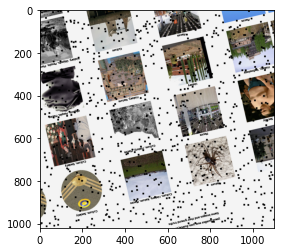

In [7]:
import cv2

transform = A.Compose([
    A.Transpose(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    A.CoarseDropout(p=0.5, always_apply=True, max_holes=800,),
])

image = cv2.imread("res/images_example.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
transformed = transform(image=image)
transformed_image = transformed["image"]
f = plt.figure()
plt.imshow(transformed_image)